## Import package

In [ ]:
#import necessary functions
import matplotlib.pyplot as plt
import numpy as np
import pycbc
from urllib.request import urlretrieve
from pycbc.frame import read_frame
from pycbc.filter import highpass, matched_filter,lowpass
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate
from scipy.signal import convolve
import scipy.stats as stats

from pycbc.catalog import Merger
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import matched_filter
from pycbc.detector import Detector

from scipy.signal import find_peaks

import matplotlib.pyplot as plt
import pycbc.noise
import pycbc.psd
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc import frame, conversions, cosmology

from pycbc.waveform.spa_tmplt import spa_length_in_time
from scipy.optimize import minimize_scalar
from tqdm import tqdm
import multiprocess
from multiprocess import Process, Queue
from multiprocess import Pool
import os
import time

## Read in data

In [2]:
#url = "https://www.gw-openscience.org/eventapi/html/O3_Discovery_Papers/GW200115_042309/v1/L-L1_GWOSC_4KHZ_R1-1263095360-4096.gwf"
url = 'https://gwosc.org/archive/data/O3b_4KHZ_R1/1256194048/L-L1_GWOSC_O3b_4KHZ_R1-1256665088-4096.gwf'
urlretrieve(url,'L-L1_GWOSC_4KHZ_R1-1256665088-4096.gwf')
channel_name = "L1:GWOSC-4KHZ_R1_STRAIN"
data = read_frame('L-L1_GWOSC_4KHZ_R1-1256665088-4096.gwf', channel_name)
h1 = data
h11 = np.nan_to_num(h1,nan=0)
h1 = pycbc.types.timeseries.TimeSeries(h11, delta_t=h1.delta_t)
h1 = highpass(h1, 10, 8)

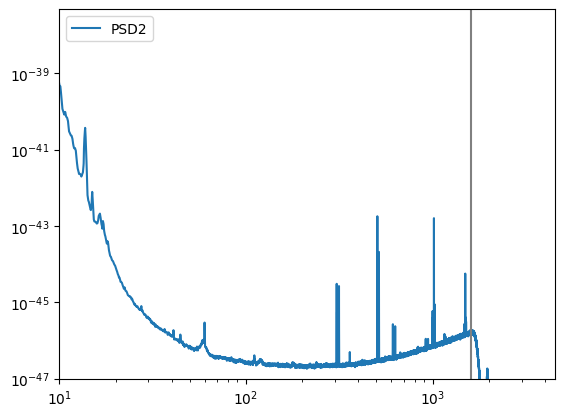

In [3]:
# Computeppsd

psd2 = interpolate(welch(h1,seg_len = int((1/h1.delta_t)*8),seg_stride = int((1/h1.delta_t)*4)),1/h1.duration)
plt.figure()
plt.loglog(psd2.sample_frequencies,psd2.data,label = "PSD2")
#plt.loglog(psd3.sample_frequencies,psd3.data,label = "PSD3")
plt.ylim(bottom = 1e-47)
plt.xlim(left = 10)
plt.axvline(x=1600, c='grey')
plt.legend()

## Generating template and Determining frequency band division

In [4]:
### Injection parameters
mass1_det_frame = 20.
mass2_det_frame = 20.
inclination_inj = np.pi/4
phase_inj = 0.
flow = 20.
right_ascension_inj = 5.3
declination_inj = 4.5
polarization_inj = 2.6
tgps0 = 1266618172.4-1266616125
det_H1 = Detector('H1')
det_L1= Detector('L1')

In [5]:
#determine frequency band division
sptilde, sctilde = get_fd_waveform(approximant="IMRPhenomD", mass1=mass1_det_frame, 
                           mass2=mass2_det_frame,
                             f_lower=20,f_final = 1/(2*h1.delta_t),delta_f=h1.delta_f)
#antennna sensitivity
fp, fc = det_H1.antenna_pattern(right_ascension=right_ascension_inj, declination=declination_inj, polarization=polarization_inj, t_gps=tgps0)
#construct template
template = fp*sptilde+fc*sctilde

#number of bands
n_band = 5
#frequency range
minf = 20
maxf = 1600
#resize the len of template to psd2
#template.resize(len(psd2_sliced))
integral = np.cumsum(((np.conj(template)*template)/psd2)*template.delta_f)
imax = np.searchsorted(template.sample_frequencies,1600)
snr_sq_max = abs(integral)[imax]
i_break = np.searchsorted(abs(integral),(snr_sq_max/n_band)*np.arange(1,n_band))
print(i_break)
imin = np.searchsorted(template.sample_frequencies,minf)
i_break_full = np.r_[imin,i_break,imax]
frequency = template.sample_frequencies[i_break_full]
print(frequency)

[188084 276245 403061 727971]
[  20.           45.91894531   67.44262695   98.40356445  177.72729492
 1600.        ]


In [6]:
hf_bands = np.zeros((n_band, len(template.data)), dtype=np.complex_)
freq_array = template.sample_frequencies.data
for ii in range(n_band):
    mask = (freq_array>frequency[ii]) & (freq_array<frequency[ii+1])
    hf_bands[ii, mask] = template.data[mask]

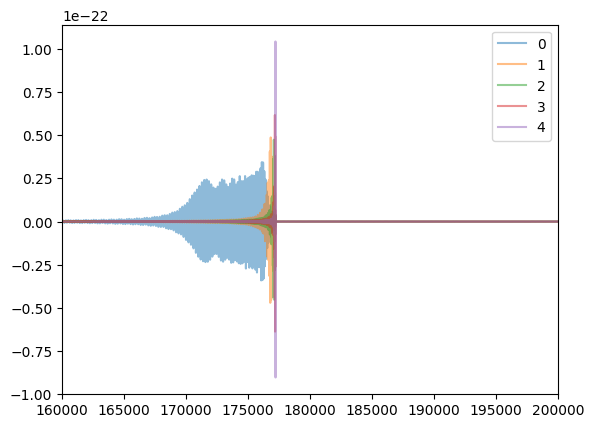

In [10]:
for i in range(len(hf_bands)):
    plt.plot(np.roll(np.fft.irfft(hf_bands[i])[int(1.65e7):int(1.70e7)], -10**5), label=i, alpha=0.5)
plt.xlim(160000,200000)
plt.legend()

## Computing for non-injection data

In [11]:
## Define the convolving parameter
averaging_length = int(10/(h1.delta_t))
window = np.ones(averaging_length)/averaging_length

In [17]:
## Compute raw SNR and lambda
bins = np.linspace(1.5, 2.5, 100)
SNR_no_injection = matched_filter(template, h1, psd=psd2, low_frequency_cutoff=10.0)
SNR_no_injection = SNR_no_injection.crop(4 + 4, 4)

lambda_w_no_injection = convolve(np.abs(SNR_no_injection.data)**2, window, mode='same')

(array([3.240000e+02, 2.720000e+02, 3.790000e+02, 2.910000e+02,
        5.020000e+02, 5.550000e+02, 4.990000e+02, 4.970000e+02,
        5.880000e+02, 3.020000e+02, 2.640000e+02, 4.350000e+02,
        3.890000e+02, 4.770000e+02, 4.890000e+02, 4.190000e+02,
        3.730000e+02, 4.800000e+02, 5.690000e+02, 4.010000e+02,
        3.320000e+02, 2.520000e+02, 3.840000e+02, 4.000000e+02,
        5.670000e+02, 9.420000e+02, 1.855000e+03, 2.357000e+03,
        8.214000e+03, 7.269000e+03, 1.609900e+04, 2.489700e+04,
        5.351200e+04, 1.045150e+05, 1.426100e+05, 2.140220e+05,
        3.464760e+05, 4.465640e+05, 5.293480e+05, 7.101060e+05,
        8.258990e+05, 8.831750e+05, 1.010939e+06, 1.071418e+06,
        1.020339e+06, 9.819110e+05, 9.028020e+05, 8.788810e+05,
        8.809950e+05, 7.463030e+05, 6.162760e+05, 5.213280e+05,
        4.063130e+05, 3.528420e+05, 2.701420e+05, 2.458110e+05,
        2.175070e+05, 2.171980e+05, 2.175470e+05, 1.709110e+05,
        1.218800e+05, 8.457700e+04, 8.33

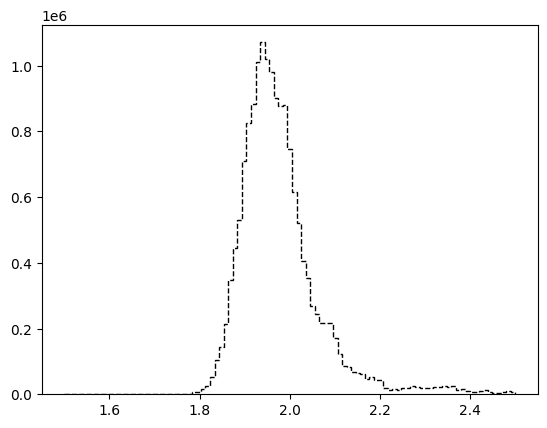

In [18]:
plt.hist(lambda_w_no_injection, bins = bins, color='k', ls='--', histtype='step')

In [14]:


z_data = []
z_data_no_injection = []
#compute z score for data
for ii in range(n_band):
    h_temp_freq = pycbc.types.FrequencySeries(hf_bands[ii,:], delta_f=h1.delta_f)
    SNR_in_band_no_injection = matched_filter(h_temp_freq, h1, psd=psd2, low_frequency_cutoff=10.0)
    SNR_in_band_no_injection = SNR_in_band_no_injection.crop(4 + 4, 4)
    z_data_no_injection.append(SNR_in_band_no_injection)


z_data_no_injection = np.asarray(z_data_no_injection)

In [15]:
convolved_z_no_injection = np.zeros([n_band,len(z_data_no_injection.T)])
#define a mask to exclude bad data
mask2 = np.abs(z_data_no_injection)**2 < 50
for i in range(n_band):
    var = np.abs(z_data_no_injection[i])**2
    weight = mask2[i]
    zzbar = convolve(var, window, mode='same')
    nsamples = convolve(weight, window, mode='same')
    convolved_z_no_injection[i] = zzbar/nsamples

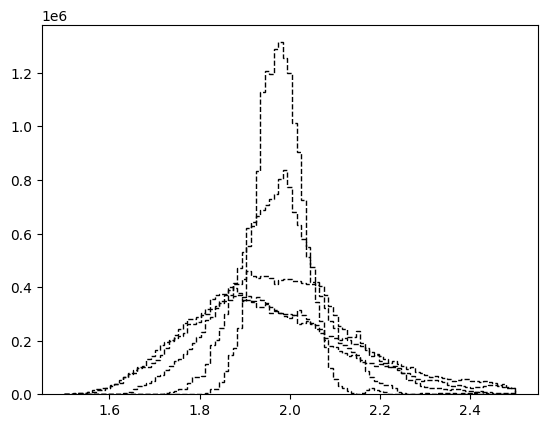

In [16]:
bins = np.linspace(1.5, 2.5, 100)
for i in range(len(convolved_z_no_injection)):
    plt.hist(convolved_z_no_injection[i], bins = bins, color='k', ls='--', histtype='step')

## Multiple injection

(array([104.,  98., 109., 101.,  98., 107.,  87.,  95.,  91., 110.]),
 array([1550. , 1639.8, 1729.6, 1819.4, 1909.2, 1999. , 2088.8, 2178.6,
        2268.4, 2358.2, 2448. ]),
 <BarContainer object of 10 artists>)

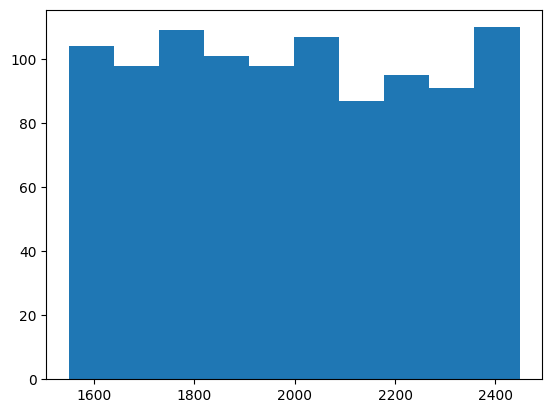

In [19]:
# Generating randomnize injection time
realization = 1000
time_inj_vec = np.random.randint(low = 1550, high = 2450, size = realization)

plt.hist(time_inj_vec)

In [20]:
## Generate injecting waveform
distance_inj = 200.  # in Mpc

# generate waveform
hpw, hcw = pycbc.waveform.get_td_waveform(approximant="IMRPhenomD",
                                        mass1 = mass1_det_frame,
                                        mass2 = mass2_det_frame,
                                        distance = distance_inj,
                                        inclination = inclination_inj,
                                        coa_phase = phase_inj,
                                        f_lower=flow,
                                        delta_t=h1.delta_t)

In [47]:
waveform_inj_vec = []
snr_recovered = []
snr_scalar_drift = []
snr_bands_drift = []
snr_bands_drift2 = []
snr_scalar_drift2 = []
t0_inj_vec = []
iteration = 11

for i in tqdm(range(realization),position = 0, leave = True,ncols = 80):
    #injecting signals with randomize time
    t_inj = time_inj_vec[i]
    hpw.start_time = hpw.start_time + t_inj
    hcw.start_time = hcw.start_time + t_inj
    waveform_injected = fp*hpw + fc*hcw
    waveform_inj_vec.append(waveform_injected)
    
    #Computing full waveform SNR
    h1_injected = h1.inject(waveform_injected)
    snr = matched_filter(template, h1_injected, psd=psd2, low_frequency_cutoff=10.0)
    snr = snr.crop(4 + 4, 4)
    
    
    z_scores = []
    #compute z score for data
    for ii in range(n_band):
    
        h_temp_freq = pycbc.types.FrequencySeries(hf_bands[ii,:], delta_f=h1_injected.delta_f)
        SNR_in_band = matched_filter(h_temp_freq, h1_injected, psd=psd2, low_frequency_cutoff=10.0)
        
        # Remove regions corrupted by filter wraparound
        SNR_in_band = SNR_in_band.crop(4 + 4, 4)
       
        z_scores.append(SNR_in_band)
        
    z_scores = np.asarray(z_scores)
    
    
    lambda_w = convolve(np.abs(snr.data)**2, window, mode='same')
    weighted_z_scalar_drift = np.sqrt(2)*snr.data/np.sqrt(lambda_w)
    weighted_z_scalar_drift_no_injection = np.sqrt(2)*snr.data/np.sqrt(lambda_w_no_injection)

    #define an empty array to store result
    var_z = np.zeros([n_band,len(z_scores.T)])
    #define a mask to exclude bad data
    mask2 = np.abs(z_scores)**2 < 50
    for i in range(n_band):
        var = np.abs(z_scores[i])**2
        weight = mask2[i]
        zzbar = convolve(var, window, mode='same')
        nsamples = convolve(weight, window, mode='same')
        var_z[i] = zzbar/nsamples

    summation = np.sum(1/var_z, axis = 0)
    
    #summation = 0
    #for i in range(len(var_z)):
        #summation = summation + (1/var_z[i])
    
    a_factor = []
    for i in range(len(var_z)):
        a_factor.append((np.sqrt(var_z[i])/np.sqrt(summation))*(1/(var_z[i])))
    
    #construct the correction statistics
    a_factor_no_injection = []
    for i in range(len(var_z)):
        a_factor_no_injection.append((np.sqrt(var_z[i])/np.sqrt(summation))*(1/(convolved_z_no_injection[i])))
    
    #define a zero array to store
    z_weighted = np.zeros(len(z_scores[0]))
    z_weighted_no_injection = np.zeros(len(z_scores[0]))
    
    
    #construct the corrected statistics
    z_weighted = np.sum(a_factor*z_scores,axis = 0)
    z_weighted_no_injection = np.sum(a_factor_no_injection*z_scores,axis = 0)
    
    #for i in range(len(z_scores)):
        #z_weighted = z_weighted + a_factor[i]*z_scores[i]
        #z_weighted_no_injection = z_weighted_no_injection + a_factor_no_injection[i]*z_scores[i]

    mask = (snr.sample_times.data>t_inj-20) & (snr.sample_times.data<t_inj+20)
    
    snr_recovered.append(max(np.abs(snr.data[mask])))
    snr_bands_drift.append(np.max(abs(z_weighted[mask])))
    snr_scalar_drift.append(np.max(abs(weighted_z_scalar_drift[mask])))
    snr_scalar_drift2.append(np.max(abs(weighted_z_scalar_drift_no_injection[mask])))
    snr_bands_drift2.append(np.max(abs(z_weighted_no_injection[mask])))
    t0_inj_vec.append(t_inj)


  9%|███▍                                   | 87/1000 [54:33<9:32:28, 37.62s/it]


KeyboardInterrupt: 

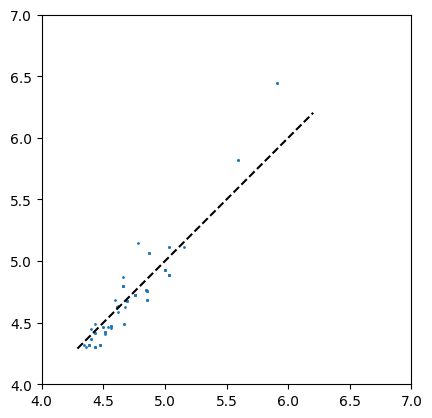

In [48]:
snr_bands_drift2 = np.asarray(snr_bands_drift2)
snr_scalar_drift2 = np.asarray(snr_scalar_drift2)
snr_recovered = np.asarray(snr_recovered)


# print(np.average(snr_bands_drift))
# print(np.average(snr_recovered))
bins = np.linspace(4,7,30)
# plt.hist(snr_bands_drift2,histtype='step',label = 'corrected',bins = bins)
# plt.hist(snr_recovered,histtype='step',label = 'recovered',bins = bins)
plt.scatter(snr_scalar_drift2, snr_bands_drift2, s=1)
xs = np.linspace(min(snr_recovered), max(snr_recovered))
plt.plot(xs, xs, ls='--', c='k')
plt.xlim((4, 7));
plt.ylim((4, 7));
plt.gca().set_aspect('equal')

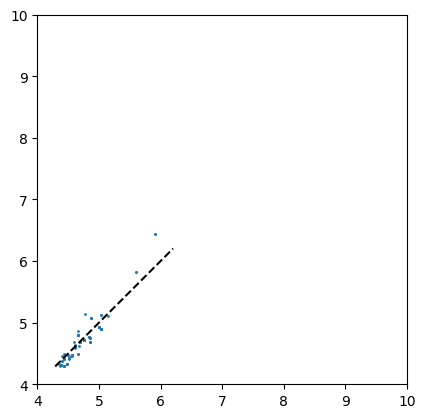

In [49]:
snr_bands_drift = np.asarray(snr_bands_drift)
snr_scalar_drift = np.asarray(snr_scalar_drift)
snr_recovered = np.asarray(snr_recovered)


# print(np.average(snr_bands_drift))
# print(np.average(snr_recovered))
bins = np.linspace(4,7,30)
# plt.hist(snr_bands_drift2,histtype='step',label = 'corrected',bins = bins)
# plt.hist(snr_recovered,histtype='step',label = 'recovered',bins = bins)
plt.scatter(snr_scalar_drift, snr_bands_drift, s=1)
xs = np.linspace(min(snr_recovered), max(snr_recovered))
plt.plot(xs, xs, ls='--', c='k')
plt.xlim((4, 10));
plt.ylim((4, 10));
plt.gca().set_aspect('equal')

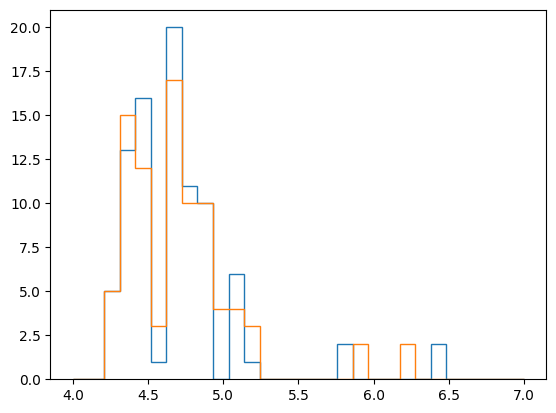

In [50]:
bins = np.linspace(4,7,30)
plt.hist(snr_bands_drift2,histtype='step',label = 'corrected',bins = bins);
plt.hist(snr_recovered,histtype='step',label = 'recovered',bins = bins);

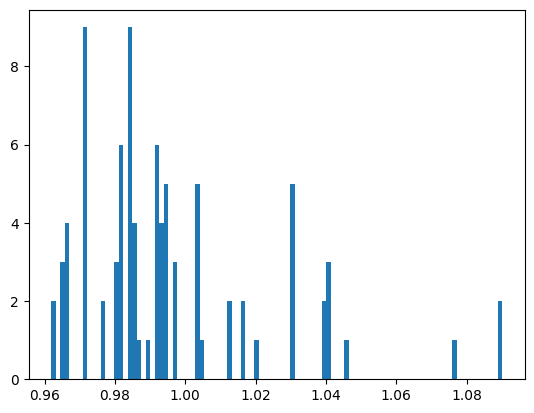

In [51]:
plt.hist(snr_bands_drift2/snr_scalar_drift2, bins=100);

In [52]:
np.mean(snr_bands_drift2/snr_scalar_drift2)

0.9957244529559997

In [53]:
np.mean(np.asarray(snr_bands_drift)/np.asarray(snr_scalar_drift))

0.9957244529559997

(array([2., 0., 3., 4., 0., 0., 0., 9., 0., 0., 0., 2., 0., 0., 3., 6., 0.,
        9., 4., 1., 0., 1., 0., 6., 4., 5., 0., 3., 0., 0., 0., 0., 5., 1.,
        0., 0., 0., 0., 0., 2., 0., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 5., 0., 0., 0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 array([0.96183526, 0.96311788, 0.9644005 , 0.96568312, 0.96696573,
        0.96824835, 0.96953097, 0.97081359, 0.97209621, 0.97337882,
        0.97466144, 0.97594406, 0.97722668, 0.97850929, 0.97979191,
        0.98107453, 0.98235715, 0.98363977, 0.98492238, 0.986205  ,
        0.98748762, 0.98877024, 0.99005285, 0.99133547, 0.99261809,
        0.99390071, 0.99518333, 0.99646594, 0.99774856, 0.99903118,
        1.0003138 , 1.00159641, 1.00287903, 1.00416165, 1.00544427,
        1.00672689, 1.0080095 , 1.00929212, 1.01057474, 1.01185736,
      

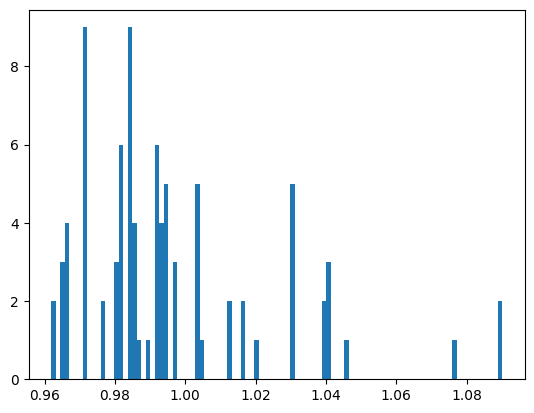

In [54]:
plt.hist(np.asarray(snr_bands_drift)/np.asarray(snr_scalar_drift), bins=100)

## Parallel Computation using Pool.imap (not working!!!)

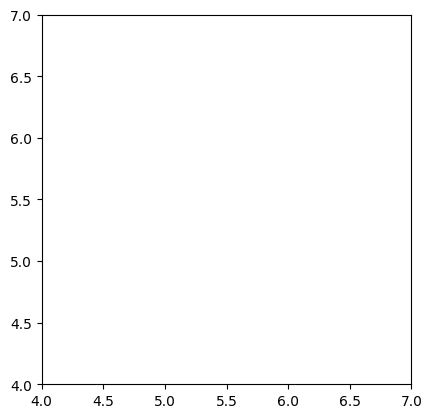

In [24]:
snr_bands_drift2 = np.asarray(snr_bands_drift2)
snr_scalar_drift2 = np.asarray(snr_scalar_drift2)
snr_recovered = np.asarray(snr_recovered)


# print(np.average(snr_bands_drift))
# print(np.average(snr_recovered))
bins = np.linspace(4,7,30)
# plt.hist(snr_bands_drift2,histtype='step',label = 'corrected',bins = bins)
# plt.hist(snr_recovered,histtype='step',label = 'recovered',bins = bins)
plt.scatter(snr_scalar_drift2, snr_bands_drift2, s=1)
xs = np.linspace(min(snr_recovered), max(snr_recovered))
plt.plot(xs, xs, ls='--', c='k')
plt.xlim((4, 7));
plt.ylim((4, 7));
plt.gca().set_aspect('equal')

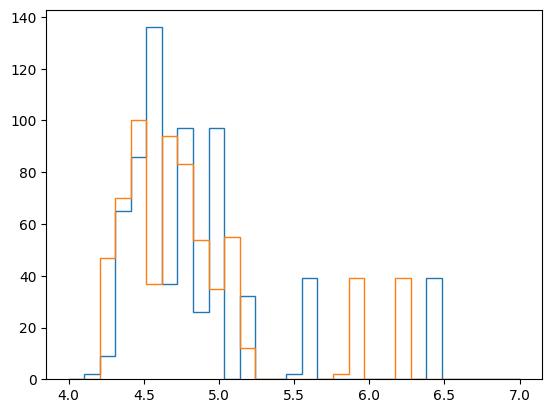

In [119]:
bins = np.linspace(4,7,30)
plt.hist(snr_bands_drift2,histtype='step',label = 'corrected',bins = bins);
plt.hist(snr_recovered,histtype='step',label = 'recovered',bins = bins);

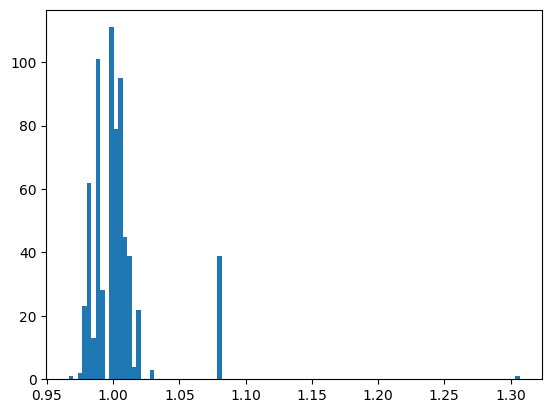

In [125]:
plt.hist(snr_bands_drift2/snr_scalar_drift2, bins=100);

In [127]:
np.mean(snr_bands_drift2/snr_scalar_drift2)

1.0034258455443161

In [120]:
print(len(snr_bands_drift))

668


In [37]:
def injections_map(i):
    #injecting signals with randomize time
    t_inj = time_inj_vec[i]
    hpw.start_time = hpw.start_time + t_inj
    hcw.start_time = hcw.start_time + t_inj
    waveform_injected = fp*hpw + fc*hcw
    waveform_inj_vec.append(waveform_injected)

    #Computing full waveform SNR
    h1_injected = h1.inject(waveform_injected)
    snr = matched_filter(template, h1_injected, psd=psd2, low_frequency_cutoff=10.0)
    snr = snr.crop(4 + 4, 4)


    z_scores = []
    #compute z score for data
    for ii in range(n_band):

        h_temp_freq = pycbc.types.FrequencySeries(hf_bands[ii,:], delta_f=h1_injected.delta_f)
        SNR_in_band = matched_filter(h_temp_freq, h1_injected, psd=psd2, low_frequency_cutoff=10.0)

        # Remove regions corrupted by filter wraparound
        SNR_in_band = SNR_in_band.crop(4 + 4, 4)

        z_scores.append(SNR_in_band)

    z_scores = np.asarray(z_scores)


    lambda_w = convolve(np.abs(snr.data)**2, window, mode='same')
    weighted_z_scalar_drift = np.sqrt(2)*snr.data/np.sqrt(lambda_w)
    weighted_z_scalar_drift_no_injection = np.sqrt(2)*snr.data/np.sqrt(lambda_w_no_injection)

    #define an empty array to store result
    var_z = np.zeros([n_band,len(z_scores.T)])
    #define a mask to exclude bad data
    mask2 = np.abs(z_scores)**2 < 50
    for i in range(n_band):
        var = np.abs(z_scores[i])**2
        weight = mask2[i]
        zzbar = convolve(var, window, mode='same')
        nsamples = convolve(weight, window, mode='same')
        var_z[i] = zzbar/nsamples

    summation = 0
    for i in range(len(var_z)):
        summation = summation + (1/var_z[i])

    a_factor = []
    for i in range(len(var_z)):
        a_factor.append((np.sqrt(2)/np.sqrt(summation))*(1/(var_z[i])))

    #construct the correction statistics
    a_factor_no_injection = []
    for i in range(len(var_z)):
        a_factor_no_injection.append((np.sqrt(2)/np.sqrt(summation))*(1/(convolved_z_no_injection[i])))

    #define a zero array to store
    z_weighted = np.zeros(len(z_scores[0]))
    z_weighted_no_injection = np.zeros(len(z_scores[0]))
    #construct the corrected statistics

    for i in range(len(z_scores)):
        z_weighted = z_weighted + a_factor[i]*z_scores[i]
        z_weighted_no_injection = z_weighted_no_injection + a_factor_no_injection[i]*z_scores[i]

    mask = (snr.sample_times.data>t_inj-20) & (snr.sample_times.data<t_inj+20)
    print(os.getpid())
    return max(np.abs(snr.data[mask])),np.max(abs(z_weighted[mask])),np.max(abs(weighted_z_scalar_drift[mask])),np.max(abs(weighted_z_scalar_drift_no_injection[mask])),np.max(abs(z_weighted_no_injection[mask]))
    #snr_recovered.append(max(np.abs(snr.data[mask])))
    #snr_bands_drift.append(np.max(abs(z_weighted[mask])))
    #snr_scalar_drift.append(np.max(abs(weighted_z_scalar_drift[mask])))
    #snr_scalar_drift2.append(np.max(abs(weighted_z_scalar_drift_no_injection[mask])))
    #snr_bands_drift2.append(np.max(abs(z_weighted_no_injection[mask])))
    #t0_inj_vec.append(t_inj)

In [ ]:
if __name__ == '__main__':
    # how many injections
    num_injection = np.arange(10)
    with Pool(processes=5) as pool:
        
        
        # Use tqdm to visualize the progress
        r = list(tqdm(pool.imap(injections_map, num_injection), total=len(num_injection)))
    
    print('finished, unpacking result')
    # unpack results from r
    for i in tqdm(range(len(r))):
        snr_recovered.append(r[i][0])
        snr_bands_drift.append(r[i][1])
        snr_scalar_drift.append(r[i][2])
        snr_scalar_drift2.append(r[i][3])
        snr_bands_drift2.append(r[i][4])

## Parallel Computation using multiprocessing.process (not working!!!)

In [44]:
waveform_inj_vec = []
snr_recovered = []
snr_scalar_drift = []
snr_bands_drift = []
snr_bands_drift2 = []
snr_scalar_drift2 = []
t0_inj_vec = []
num_per_iteration = 5
def injections(j,scalar_drift_ouput,scalar_drift2_ouput,recovered_output,band_drift_output,band_drift2_output):
    
    print(os.getpid())
    for i in tqdm(range(num_per_iteration*j,num_per_iteration*(j+1))):
        
        #injecting signals with randomize time
        t_inj = time_inj_vec[i]
        hpw.start_time = hpw.start_time + t_inj
        hcw.start_time = hcw.start_time + t_inj
        waveform_injected = fp*hpw + fc*hcw
        waveform_inj_vec.append(waveform_injected)

        #Computing full waveform SNR
        h1_injected = h1.inject(waveform_injected)
        snr = matched_filter(template, h1_injected, psd=psd2, low_frequency_cutoff=10.0)
        snr = snr.crop(4 + 4, 4)


        z_scores = []
        #compute z score for data
        for ii in range(n_band):

            h_temp_freq = pycbc.types.FrequencySeries(hf_bands[ii,:], delta_f=h1_injected.delta_f)
            SNR_in_band = matched_filter(h_temp_freq, h1_injected, psd=psd2, low_frequency_cutoff=10.0)

            # Remove regions corrupted by filter wraparound
            SNR_in_band = SNR_in_band.crop(4 + 4, 4)

            z_scores.append(SNR_in_band)

        z_scores = np.asarray(z_scores)


        lambda_w = convolve(np.abs(snr.data)**2, window, mode='same')
        weighted_z_scalar_drift = np.sqrt(2)*snr.data/np.sqrt(lambda_w)
        weighted_z_scalar_drift_no_injection = np.sqrt(2)*snr.data/np.sqrt(lambda_w_no_injection)

        #define an empty array to store result
        var_z = np.zeros([n_band,len(z_scores.T)])
        #define a mask to exclude bad data
        mask2 = np.abs(z_scores)**2 < 50
        for i in range(n_band):
            var = np.abs(z_scores[i])**2
            weight = mask2[i]
            zzbar = convolve(var, window, mode='same')
            nsamples = convolve(weight, window, mode='same')
            var_z[i] = zzbar/nsamples

        summation = 0
        for i in range(len(var_z)):
            summation = summation + (1/var_z[i])

        a_factor = []
        for i in range(len(var_z)):
            a_factor.append((np.sqrt(2)/np.sqrt(summation))*(1/(var_z[i])))

        #construct the correction statistics
        a_factor_no_injection = []
        for i in range(len(var_z)):
            a_factor_no_injection.append((np.sqrt(2)/np.sqrt(summation))*(1/(convolved_z_no_injection[i])))

        #define a zero array to store
        z_weighted = np.zeros(len(z_scores[0]))
        z_weighted_no_injection = np.zeros(len(z_scores[0]))
        #construct the corrected statistics

        for i in range(len(z_scores)):
            z_weighted = z_weighted + a_factor[i]*z_scores[i]
            z_weighted_no_injection = z_weighted_no_injection + a_factor_no_injection[i]*z_scores[i]

        mask = (snr.sample_times.data>t_inj-20) & (snr.sample_times.data<t_inj+20)

        snr_recovered.append(max(np.abs(snr.data[mask])))
        snr_bands_drift.append(np.max(abs(z_weighted[mask])))
        snr_scalar_drift.append(np.max(abs(weighted_z_scalar_drift[mask])))
        snr_scalar_drift2.append(np.max(abs(weighted_z_scalar_drift_no_injection[mask])))
        snr_bands_drift2.append(np.max(abs(z_weighted_no_injection[mask])))
        t0_inj_vec.append(t_inj)
        scalar_drift_ouput.put(snr_bands_drift)
        scalar_drift2_ouput.put(snr_bands2_drift)
        recovered_output.put(snr_recovered)
        band_drift_output.put(snr_bands_drift)
        band_drift2_output.put(snr_bands_drift2)

In [59]:
if __name__ == '__main__':

    ##Initializing Quene
    scalar_drift_ouput_queue = Queue()
    scalar_drift2_ouput_queue = Queue()
    recovered_output_queue = Queue()
    band_drift_output_queue = Queue()
    band_drift2_output_queue = Queue()
    #Initializing process list
    process_list = []
    
    ##Executing Process
    for i in range(5):
        p = multiprocessing.Process(target=injections,args=(i, scalar_drift_ouput_queue,scalar_drift2_ouput_queue,recovered_output_queue,
                                                           band_drift_output_queue,band_drift2_output_queue))
        p.start()
        process_list.append(p)
    for i in process_list:
        p.join()
    
    ##Initializing list to store final result
    scalar_drift = []
    scalar_drift2 = []
    recovered = []
    band_drift = []
    band_drift2 = []
    
    ## Retrieve results from the Queue
    while not scalar_drift_ouput_queue.empty():
        scalar_drift.append(scalar_drift_ouput_queue.get())  
    while not scalar_drift2_ouput_queue.empty():
        scalar_drift2.append(scalar_drift_ouput_queue.get())
    while not recovered_output_queue.empty():
        recovered.append(scalar_drift_ouput_queue.get())
    while not band_drift_output_queue.empty():
        band_drift.append(band_drift_output_queue.get())
    while not band_drift2_output_queue.empty():
        band_drift2.append(band_drift2_output_queue.get())

KeyboardInterrupt: 